In [25]:
import os
if not os.path.exists("../data/macd.csv"):
    !wget --no-check-certificate \
     https://pai-public-data.oss-cn-beijing.aliyuncs.com/public-dataset/all_stocks_5yr.csv -O ../data/macd.csv

In [4]:
# 首先需要先把数据集下载到 download中
# 获取股票数据
"""
import fix_yahoo_finance as yf
tickers = ['AAPL', 'BABA', 'BIDU', 'GOOGL', 'FB', 'AMZN']
data = yf.download(tickers = tickers, start = '2020-01-01', end = '2020-12-31')
data.to_csv('./macd.csv')
"""
import pandas as pd
data = pd.read_csv('../data/macd.csv')
data

,Unnamed: 0,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Adj Close.5,Close,Close.1,Close.2,...,Open.2,Open.3,Open.4,Open.5,Volume,Volume.1,Volume.2,Volume.3,Volume.4,Volume.5
0,NaN,AAPL,AMZN,BABA,BIDU,FB,GOOGL,AAPL,AMZN,BABA,...,BABA,BIDU,FB,GOOGL,AAPL,AMZN,BABA,BIDU,FB,GOOGL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-31,72.68,1847.84,212.1,126.4,205.25,1339.39,73.41,1847.84,212.1,...,212.0,125.53,204.0,1335.79,100805600,2506500,6773600,1863900,8953500,975700
3,2020-01-02,74.33,1898.01,219.77,138.22,209.78,1368.68,75.09,1898.01,219.77,...,216.6,129.49,206.75,1348.41,135480400,4029000,15873500,8001400,12077100,1363900
4,2020-01-03,73.61,1874.97,217.0,133.8,208.67,1361.52,74.36,1874.97,217.0,...,216.35,134.58,207.21,1348.0,146322800,3764400,8604500,5184800,11188400,1170400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-12-23,130.76,3185.27,256.18,193.36,268.11,1728.23,130.96,3185.27,256.18,...,255.5,191.35,266.89,1723.93,88223700,2093800,10729200,5438400,14329000,1148700
251,2020-12-24,131.77,3172.69,222.0,191.02,267.4,1734.16,131.97,3172.69,222.0,...,228.24,189.75,268.88,1729.0,54930100,1451900,141830000,2978900,6702000,465600
252,2020-12-28,136.49,3283.96,222.36,193.08,277.0,1773.96,136.69,3283.96,222.36,...,216.88,189.63,268.74,1744.91,124486200,5686800,73512100,5685900,23299700,1382500
253,2020-12-29,134.67,3322.0,236.26,195.07,276.78,1757.76,134.87,3322.0,236.26,...,231.76,195.97,276.95,1787.23,121047300,4872900,69715900,5723600,16383000,986300


In [12]:
!pip install yfinance fix-yahoo-finance

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import fix_yahoo_finance as yf
import yfinance as yf

# 计算df的 短期平均ma1, 长期平均ma2
def macd(df):
    # 计算MA1和MA2
    df['ma1']=df['Close'].rolling(window=ma1, min_periods=1).mean()
    df['ma2']=df['Close'].rolling(window=ma2, min_periods=1).mean()
    return df

"""
    当短均线大于长均线时，我们看多并持有
    当短均线小于长均线时，我们清仓
    背后的逻辑是短均线有动量的影响（惯性）
    我们可以用 diff = 长均线-短均线
    diff有时正，有时负
    这就是为什么称为 Moving Average Convergence Divergence
"""
def signal_compute(df):
    # 计算短期平均ma1, 长期平均ma2
    df = macd(df)
    # 初始化positions均为0
    df['positions'] = 0

    # 当短均线 > 长均线， positions=1
    df['positions'][ma1:] = np.where(df['ma1'][ma1:]>=df['ma2'][ma1:],1,0)

    # positions 表明了需要持有，计算前后两天的positions diff，代表交易信号 signals
    # signals=1 买入，signals=-1 卖出
    df['signals'] = df['positions'].diff()

    # 震荡diff = 两个移动平均之差
    df['diff'] = df['ma1']-df['ma2']
    return df

# 绘制回测结果
def plot(df, ticker):    
    #the first plot is the actual close price with long/short positions
    # 绘制实际的股票收盘数据
    fig=plt.figure(figsize=(12, 6))
    ax=fig.add_subplot(111)    
    ax.plot(df.index, df['Close'], label=ticker)
    # 只显示时刻点，不显示折线图 => 设置 linewidth=0
    ax.plot(df.loc[df['signals']==1].index, df['Close'][df['signals']==1], label='Buy', linewidth=0, marker='^', c='g')
    ax.plot(df.loc[df['signals']==-1].index, df['Close'][df['signals']==-1], label='Sell', linewidth=0, marker='v', c='r')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.show()
    
    # 显示diff, 即ma1-ma2
    fig=plt.figure(figsize=(12, 6))
    cx=fig.add_subplot(211)
    df['diff'].plot(kind='bar',color='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([]) # 不显示x轴刻度
    #plt.xlabel('')
    plt.title('MACD Diff (ma1-ma2)')
    
    # 绘制ma1, ma2曲线
    bx=fig.add_subplot(212)
    bx.plot(df.index, df['ma1'], label='ma1')
    bx.plot(df.index, df['ma2'], label='ma2', linestyle=':')
   
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [16]:
# MACD简单有效，但是需要注意一个问题，就是：进入信号总是很晚，需要注意向下的均线
# 可以采用12,26 也可以采用 10和21
ma1 = 12
ma2 = 26

# 使用slicer进行切片，如果数据很大，回测曲线会比较乱，因为有太多的标记挤在一起
slicer = 0

# 获取某一支股票的数据
"""
data = yf.download(tickers='AAPL', start='2020-01-01', end='2020-12-31')
data
"""
data = pd.read_csv('../data/AAPL_macd.csv', index_col='Date')
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,72.48,73.42,72.38,73.41,72.68,100805600
2020-01-02,74.06,75.15,73.80,75.09,74.33,135480400
2020-01-03,74.29,75.14,74.12,74.36,73.61,146322800
2020-01-06,73.45,74.99,73.19,74.95,74.20,118387200
2020-01-07,74.96,75.22,74.37,74.60,73.85,108872000
...,...,...,...,...,...,...
2020-12-23,132.16,132.43,130.78,130.96,130.76,88223700
2020-12-24,131.32,133.46,131.10,131.97,131.77,54930100
2020-12-28,133.99,137.34,133.51,136.69,136.49,124486200


In [20]:
#pd.set_option('max_rows', None)
pd.options.display.max_rows = None
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

# 计算ma1, ma2, positions, signals, diff指标
df = signal_compute(data)
df.index = pd.to_datetime(df.index)
df

/tmp/ipykernel_134/2786558916.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positions'][ma1:] = np.where(df['ma1'][ma1:]>=df['ma2'][ma1:],1,0)


,Open,High,Low,Close,Adj Close,Volume,ma1,ma2,positions,signals,diff
Date,,,,,,,,,,,
2019-12-31,72.48,73.42,72.38,73.41,72.68,100805600,73.410000,73.410000,0,NaN,0.000000
2020-01-02,74.06,75.15,73.80,75.09,74.33,135480400,74.250000,74.250000,0,0.0,0.000000
2020-01-03,74.29,75.14,74.12,74.36,73.61,146322800,74.286667,74.286667,0,0.0,0.000000
2020-01-06,73.45,74.99,73.19,74.95,74.20,118387200,74.452500,74.452500,0,0.0,0.000000
2020-01-07,74.96,75.22,74.37,74.60,73.85,108872000,74.482000,74.482000,0,0.0,0.000000
2020-01-08,74.29,76.11,74.29,75.80,75.04,132079200,74.701667,74.701667,0,0.0,0.000000
2020-01-09,76.81,77.61,76.55,77.41,76.63,170108400,75.088571,75.088571,0,0.0,0.000000
2020-01-10,77.65,78.17,77.06,77.58,76.80,140644800,75.400000,75.400000,0,0.0,0.000000
2020-01-13,77.91,79.27,77.79,79.24,78.44,121532000,75.826667,75.826667,0,0.0,0.000000


In [21]:
print('买入信号:', df.loc[df['signals']==1].index)
print('买入信号时的收盘价', df['Close'][df['signals']==1])
print('卖出信号:', df.loc[df['signals']==-1].index)

买入信号: DatetimeIndex(['2020-01-17', '2020-04-13', '2020-10-09', '2020-11-17'], dtype='datetime64[ns]', name='Date', freq=None)
买入信号时的收盘价 Date
2020-01-17     79.68
2020-04-13     68.31
2020-10-09    116.97
2020-11-17    119.39
Name: Close, dtype: float64
卖出信号: DatetimeIndex(['2020-02-25', '2020-09-17', '2020-10-30'], dtype='datetime64[ns]', name='Date', freq=None)


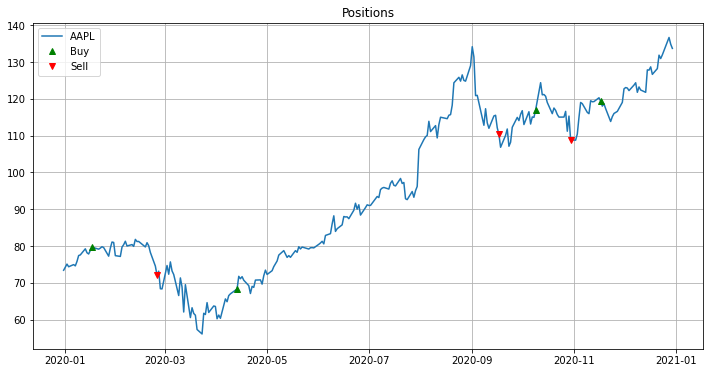

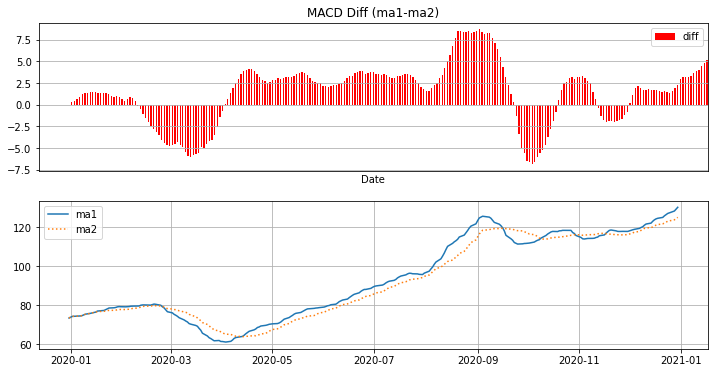

In [22]:
plot(df, 'AAPL')

In [23]:
# 信号的分布
df['signals'].value_counts()

 0.0    245
 1.0      4
-1.0      3
Name: signals, dtype: int64

In [24]:
df['positions'].value_counts()

1    180
0     73
Name: positions, dtype: int64